In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv", nrows = 1000000)  ## the whole trainning data set is quite huge so we sample only the first 1M rows 

## Exploratory Data Analysis

In [3]:
train.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
key                  1000000 non-null object
fare_amount          1000000 non-null float64
pickup_datetime      1000000 non-null object
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999990 non-null float64
dropoff_latitude     999990 non-null float64
passenger_count      1000000 non-null int64
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


Since there are only 10 missing data in dropoff coordinates, dropping them off won't make any impact to our model. 

In [5]:
train = train.dropna()

Convert pickup_datetime to datetime class and extract year, day of week and hour data to see if we can find some patterns.

In [6]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train["pickup_year"] = train["pickup_datetime"].dt.year
train["pickup_dow"] = train["pickup_datetime"].dt.dayofweek
train["pickup_hour"] = train["pickup_datetime"].dt.hour

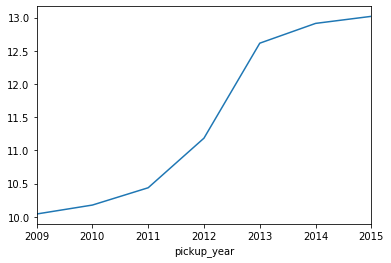

In [7]:
train.groupby("pickup_year")["fare_amount"].mean().plot()

Average taxi fare ramped up year over year but closed to saturate in 2015, it seems that year can be a good feature to predict fare. 

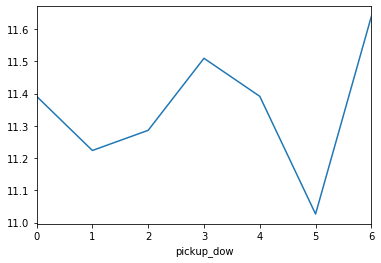

In [8]:
train.groupby("pickup_dow")["fare_amount"].mean().plot()

Average fare hits the lowest on Friday and hikes up on Saturday.

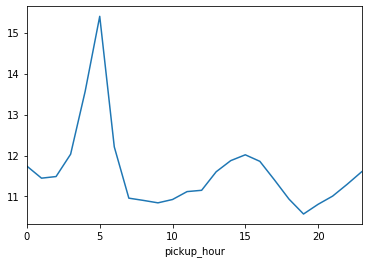

In [9]:
train.groupby("pickup_hour")["fare_amount"].mean().plot()

Taxi fare has 3 peaks in a day, 4-6, 14-16 and 23-1. Fare tends to go up in after-midnight which could due to surcharge or the fact that public transportations are closed so commuters have to hire taxi instead even for long trip.

Next we are curious about to what extent travel distance is relevent to taxi fare so we calculate line distance between pickup and dropoff point. We convert coordinate to distance in km because latitude and longitude have different distance(one degree of lat = 111km; one degree of long = 85km).

In [10]:
train["move_latitude"] = (train["dropoff_latitude"] - train["pickup_latitude"]) * 111
train["move_longitude"] = (train["dropoff_longitude"] - train["pickup_longitude"]) * 85
train["abs_distance"] = np.hypot(train["move_latitude"], train["move_longitude"])

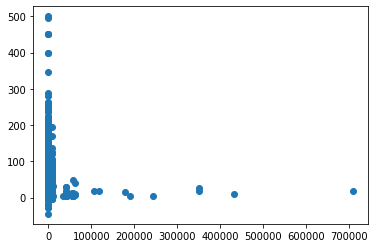

In [11]:
plt.scatter(train["abs_distance"], train["fare_amount"])

It seems that distance and fare have week correlation but we see some of the travel distance are unfairly long, they might be outside of NYC already.

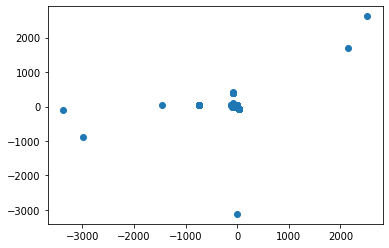

In [12]:
plt.scatter(train["pickup_longitude"], train["pickup_latitude"])

From the pickup coordinates plot, indeed there are some data points are unrealistic that we need to clean up.  
The coordinates of NYC is (-73.9, 40.7) and we expect pickup coordinates to be within one degree of NYC.

In [13]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_dow,pickup_hour,move_latitude,move_longitude,abs_distance
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941,2011.741103,3.039870,13.509463,-1.008522,-0.098606,21.665121
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907,1.860761,1.949966,6.513855,918.171251,652.732766,1126.334834
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000,2009.000000,0.000000,0.000000,-608957.037063,-360433.063130,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000,2010.000000,1.000000,9.000000,-1.523031,-0.958120,1.216958
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000,2012.000000,3.000000,14.000000,0.000000,0.031195,2.121506
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000,2013.000000,5.000000,19.000000,1.555443,1.158550,3.888289
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000,2015.000000,6.000000,23.000000,350435.145291,239934.790570,707630.317317


There are three parts of abnormal data that we need to drop off before proceeding the analysis  
a. pickup coordinates are not within one degree of NYC(-73.9, 40.7)  
b. travel distance greater than 100 km  
c. zero or negative fare amount

In [14]:
train = train[train["fare_amount"] > 0]

longtitude_range = (train["pickup_longitude"] <= -73.4) & (train["pickup_longitude"]  >= -74.4)
latitude_range = (train["pickup_latitude"] <= 41.2) & (train["pickup_latitude"] >= 40.2)
train_trim = train[longtitude_range & latitude_range]

train_trim = train_trim[(train_trim["abs_distance"] < 100) & (train_trim["abs_distance"] > 0)]

In [15]:
train_trim.shape[0]/train.shape[0]

0.9685085751602873

After trimmed out all the abnormal data, we still have around 97% of data left.

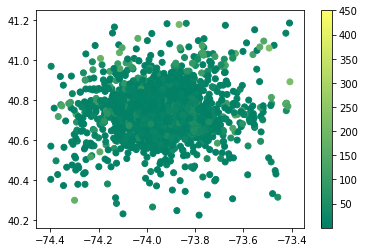

In [16]:
sc = plt.scatter(train_trim["pickup_longitude"], train_trim["pickup_latitude"], c = train_trim["fare_amount"], cmap = "summer")
plt.colorbar(sc)

Unfortunately, by plotting out pickup coordinates with color representing fare amount we're still not able to see clear boundries seperating areas with different level of taxi fare.

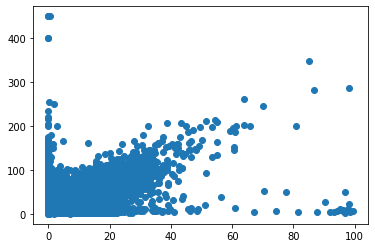

In [17]:
plt.scatter(train_trim["abs_distance"], train_trim["fare_amount"])

After clearing abnormal data, the correlationship between travel distance and fare becomes more clear. We print out correlation coefficient of fare_amount and other variables at below, it shows 0.86 for abs_distance which is very high. Other medium-highly correlated variables are pickup_longitude and dropoff_longitude, can be explained that traveling from/to the east side of NYC would have higher taxi cost.

In [18]:
train_trim.corr()["fare_amount"].sort_values(ascending = False)

fare_amount          1.000000
abs_distance         0.863739
pickup_longitude     0.426462
dropoff_longitude    0.317211
pickup_year          0.118346
move_latitude        0.017087
passenger_count      0.015063
pickup_dow           0.002513
pickup_hour         -0.019109
move_longitude      -0.090367
dropoff_latitude    -0.163379
pickup_latitude     -0.208793
Name: fare_amount, dtype: float64

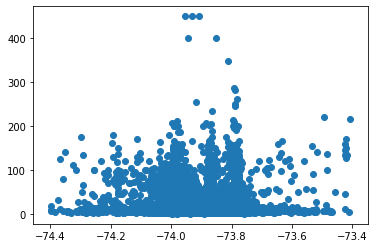

In [19]:
plt.scatter(train_trim["pickup_longitude"], train_trim["fare_amount"])

Lastly we want to check whether travel orientation contributes to taxi fare so we categorize the data into east/west and north/south.

In [20]:
train_trim["toward_east"] = train_trim["move_longitude"] > 0
train_trim["toward_north"] = train_trim["move_latitude"] > 0

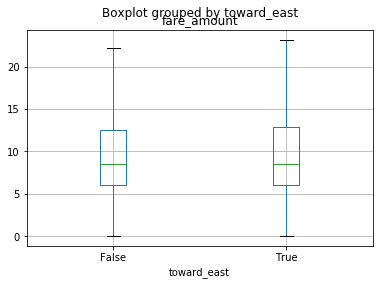

In [21]:
train_trim.boxplot(column = ["fare_amount"], by = "toward_east", showfliers = False)

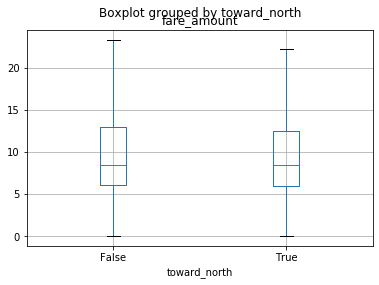

In [22]:
train_trim.boxplot(column = ["fare_amount"], by = "toward_north", showfliers = False)

Unfortunately, no matter which two of opposite orientations, the distributions of fare amount don't seem to have too much difference. 

In [23]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.compose import ColumnTransformer

## Features Preprocessing Pipeline

After exploring the data, we get to know that which are good features to feed into predictive models to predict taxi fare,  
-Categorical: pickup hour and pickup day of week  
-Numerical: pickup year, travel distance, pickup longitude and dropoff longitude  
Before training our data, we build pipelines that can handle preprocessing for each type of features respectively then combine together, for example, categorical features have to be encoded to multiple binaries as inputs and numerical features require scaling to have a better performance in certain machine learning algorithms.

In [24]:
## group pickup hour into bins in order to reduce model runtime
class HourlyBins(BaseEstimator, TransformerMixin): 
    def __init__(self, bins = 8):
        self.bins = bins
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):    
        pickup_hour_bin = np.array(pd.cut(X[X.columns[0]], self.bins))
        return pickup_hour_bin.reshape(-1, 1)

In [25]:
hour_pipe = Pipeline([
    ('hourlybins', HourlyBins()),
    ('encoder', OneHotEncoder(categories='auto', sparse = False)),
])

ct_pipe = ColumnTransformer(transformers=[
    ('hourly_cat', hour_pipe, ["pickup_hour"]),
    ('encoder', OneHotEncoder(categories='auto', sparse = False), ["pickup_dow"]),
    ('std_scaler', StandardScaler(), ["pickup_year", "abs_distance", "pickup_longitude", "dropoff_longitude"])
])

In [50]:
## build a function that can break raw data into independent variables and dependent variable for the models
def XandY(df, test_set = False):
    df = df.copy()
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df["pickup_year"] = df["pickup_datetime"].dt.year.astype(float)
    df["pickup_dow"] = df["pickup_datetime"].dt.dayofweek
    df["pickup_hour"] = df["pickup_datetime"].dt.hour
    df["abs_distance"] = np.hypot(df["dropoff_latitude"]-df["pickup_latitude"], df["dropoff_longitude"]-df["pickup_longitude"])
    df_X = df[["pickup_year", "pickup_dow", "pickup_hour", "abs_distance", "pickup_longitude", "dropoff_longitude"]]
    if test_set == True:
        return df_X
    else:
        df_y = df["fare_amount"]
        return df_X, df_y

train_X, train_y = XandY(train_trim)

## Linear Regression

In [29]:
lr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('lin_reg', LinearRegression())
]) 
lr_score = cross_val_score(lr_pipe, train_X, train_y, scoring = "neg_mean_squared_error", cv = 5)
lr_rmse = np.sqrt(-lr_score)
lr_rmse.mean()

4.594289204810396

## Polynomial Regression

Before fitting a polynomial regression, we have to add polynomial features for numerical variables, we build this into preprocessing pipelines then we can do grid search on different degrees of polynomial more easily.

In [30]:
poly_pipe = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('std_scaler', StandardScaler())
])

poly_ct_pipe = ColumnTransformer(transformers=[
    ('hourly_cat', hour_pipe, ["pickup_hour"]),
    ('encoder', OneHotEncoder(categories='auto', sparse = False), ["pickup_dow"]),
    ('poly', poly_pipe, ["pickup_year", "abs_distance", "pickup_longitude", "dropoff_longitude"])
])

polyreg_pipe = Pipeline([
    ('poly_ct', poly_ct_pipe),
    ('reg', LinearRegression())
])

param_grid = {'poly_ct__poly__poly_features__degree': [2,3,5], 'poly_ct__poly__poly_features__include_bias': [False, True]}
polyreg_gs = GridSearchCV(polyreg_pipe, param_grid, cv = 5, scoring = "neg_mean_squared_error")
polyreg_gs.fit(train_X, train_y)
polyreg_gs.best_params_

{'poly_ct__poly__poly_features__degree': 3,
 'poly_ct__poly__poly_features__include_bias': True}

In [31]:
np.sqrt(-polyreg_gs.best_score_)

4.210495364668295

Polynomial regression improves the prediction error by 8%.

## Random Forest Regression

In [30]:
rfr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('forest_reg', RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 3))
])

rfr_score = cross_val_score(rfr_pipe, train_X, train_y, scoring = "neg_mean_squared_error", cv = 5)
rfr_rmse = np.sqrt(-rfr_score)
rfr_rmse.mean()

4.053465004839071

Random forest regression so far the best performer before even tuning the hyperparameters so we're keen to see if we can bring down the error with grid searches.

In [65]:
param_grid = {'forest_reg__n_estimators': [10, 20], 'forest_reg__max_features': [4, 8, 'auto']}
forest_gs = GridSearchCV(rfr_pipe, param_grid, cv = 5, scoring = "neg_mean_squared_error")
forest_gs.fit(train_X, train_y)
forest_gs.best_params_

{'forest_reg__max_features': 8, 'forest_reg__n_estimators': 20}

In [36]:
np.sqrt(-forest_gs.best_score_)

3.9138987431342045

In [32]:
np.sqrt(-forest_gs.cv_results_["mean_test_score"])

array([4.10013607, 3.98669732, 4.01173281, 3.91389874, 4.05675042,
       3.96155833])

From the grid search results we see different max_features don't make too much difference in error, so as n_estimators, however we see with bigger estimators the errors are improved consistently so it's worth to try an even bigger n_estimators.

In [31]:
rfr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('forest_reg', RandomForestRegressor(n_estimators = 50, max_features = 8, n_jobs = -1, random_state = 3))
])

rfr_score = cross_val_score(rfr_pipe, train_X, train_y, scoring = "neg_mean_squared_error", cv = 5)
rfr_rmse = np.sqrt(-rfr_score)
rfr_rmse.mean()

3.8528172950838346

When n_estimators = 50, the RMSE only improves by 1.5%. However it takes much more time to fit the model. It's suggested to stick with the last one as the best model.

## SVM Regression

In [27]:
svr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('lin_svr', LinearSVR())
]) 

param_grid = {'lin_svr__epsilon': [0.5, 1, 2, 4]}
svr_gs = GridSearchCV(svr_pipe, param_grid, cv = 5, scoring = "neg_mean_squared_error")
svr_gs.fit(train_X, train_y)
svr_gs.best_params_

{'lin_svr__epsilon': 2}

In [28]:
np.sqrt(-svr_gs.best_score_)

4.60658321966807

Linear SVR yields the similar performance as linear regression after grid search. We then try another non-linear SVR with RBF kernel.

In [28]:
ksvr_pipe = Pipeline([
    ('ct', ct_pipe),
    ('rbf_svr', SVR(kernel = "rbf", gamma = "auto", max_iter = 1000))  ## need to cap a maximum iteration otherwise it would take forever to fit 
]) 

param_grid = {'rbf_svr__C': [0.5, 2, 8]}
ksvr_gs = GridSearchCV(ksvr_pipe, param_grid, cv = 5, scoring = "neg_mean_squared_error", n_jobs = -1)
ksvr_gs.fit(train_X, train_y)
ksvr_gs.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'rbf_svr__C': 8}

In [29]:
np.sqrt(-ksvr_gs.best_score_)

10.594365994738459

This model seems to be way far from the optimal solution at the 1000th iteration, however, due to long fitting runtime it won't be so efficient to extend further.

## Apply Model to Test Set

Now we've tested a handful of models and decide to choose `forest_gs.best_estimator` as the final model since it has both accuracy and speed. Next step is to show how to apply the model to new test data and make predictions.

In [66]:
test = pd.read_csv("test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 542.2+ KB


In [67]:
test_X = XandY(test, test_set = True)

In [68]:
final_model = forest_gs.best_estimator_
test["fare_amount_pred"] = final_model.predict(test_X)

In [69]:
test.head(10)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_pred
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,13.2500
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,11.6250
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,4.4600
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,9.5250
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,13.0250
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1,11.2000
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1,5.6400
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1,49.0685
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.014099,40.709638,-73.995106,40.741365,1,10.3800
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20 UTC,-73.969582,40.765519,-73.980686,40.770725,1,6.4750
